# Tutorial 01 - Visualizing Pupillometry Data
In this tutorial we will load and visualize pupillometry data that was previously exported from Pupil Player. More specifically we will 
1. visualize the pupil diameter as a function of time and 
1. the spatial distribution of pupil positions in the eye image. 
All we need for this is Pandas and Matplotlib!

We start by importing the required packages, defining the location of our sample data and printing a list of all available files. The original recording - coming out of Pupil Capture, Pupil Service or Pupil Mobile - is located in `recording_location`. Exports from Pupil Player will be saved in a subfolder of the recording folder called `exports`. Every time we export something, a new folder will be created in `exports` containing the data of that session. In our sample data, there is only one export inside the folder `000`.

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

recording_location = '/home/mt/recordings/2018_07_23/000'
recording_location = os.path.expanduser(recording_location)
export_location = os.path.join(recording_location, 'exports', '000')

print("Files contained in {}:".format(export_location))
for file in os.listdir(export_location):
    print(file)

Files contained in /home/mt/recordings/2018_07_23/000/exports/000:
pupil_positions.csv
gaze_positions.csv
world_viz_timestamps.npy
pupil_gaze_positions_info.txt
export_info.csv
world_viz.mp4


### Available Files
Files like the ones above will be contained in every export.

`world_viz.mp4` - Contains the exported section of the scene video.

`export_info.csv` - Contains meta information on the exported data, e.g. export time.

`pupil_positions.csv` - A list of all pupil datums.

`gaze_positions.csv` - A list of all gaze datums.

`pupil_gaze_positions_info.txt` - Contains documentation on how to interpret `pupil_positions.csv` and `gaze_positions.csv`

Some Pupil Player plugins might add additional files.


In this tutorial we are interested in visualizing pupillometry data, therefore we will load `pupil_positions.csv`. We use Pandas to load the CSV-file into a Python dictionary.

In [18]:
exported_pupil_csv = os.path.join(export_location, 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)

In [19]:
print("Columns present in pupil data:")
print(pupil_pd_frame.columns)

Columns present in pupil data:
Index(['timestamp', 'index', 'id', 'confidence', 'norm_pos_x', 'norm_pos_y',
       'diameter', 'method', 'ellipse_center_x', 'ellipse_center_y',
       'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle', 'diameter_3d',
       'model_confidence', 'model_id', 'sphere_center_x', 'sphere_center_y',
       'sphere_center_z', 'sphere_radius', 'circle_3d_center_x',
       'circle_3d_center_y', 'circle_3d_center_z', 'circle_3d_normal_x',
       'circle_3d_normal_y', 'circle_3d_normal_z', 'circle_3d_radius', 'theta',
       'phi', 'projected_sphere_center_x', 'projected_sphere_center_y',
       'projected_sphere_axis_a', 'projected_sphere_axis_b',
       'projected_sphere_angle'],
      dtype='object')


### Individual Datums
As we can see every datum contains many values. Most of them are concerned with the state of the 3D eye model. We will now take a closer look at the subset of values most important in our use case regarding pupillometry: 

- `timestamp` - The timestamp at which the sample was recorded.
- `id` - Identifies the eye to which the sample belongs to. By default samples with `id = 0` belong to the right eye, while samples with `id = 1` belong to the left eye. 
- `confidence` - Confidence in the pupil detection.
- `index` - The world frame this sample matches too. By default the eye cameras record more frames per second than the world camera. Therefore, there is not a one-to-one mapping between the images of each eye camera and the world camera. Instead multiple eye images are mapped to the same world frame via this index.
- `norm_pos` - The position of the pupil in the eye image
- `diameter` - The pupil diameter

Let's take a look at a few values from our sample data!

In [36]:
eye0_df = pupil_pd_frame[pupil_pd_frame.id == 0]
eye1_df = pupil_pd_frame[pupil_pd_frame.id == 1]
pd.options.display.float_format = '{:.3f}'.format

print("eye0 data:")
print(eye0_df[['timestamp', 'id', 'confidence', 'index', 'norm_pos_x', 'norm_pos_y', 'diameter']][:10])
print("eye1 data:")
print(eye1_df[['timestamp', 'id', 'confidence', 'index', 'norm_pos_x', 'norm_pos_y', 'diameter']][:10])

eye0 data:
     timestamp  id  confidence  index  norm_pos_x  norm_pos_y  diameter
0  1847246.003   0       1.000      3       0.367       0.586    30.975
2  1847246.011   0       1.000      3       0.368       0.587    30.801
4  1847246.019   0       1.000      3       0.367       0.586    30.650
6  1847246.027   0       1.000      3       0.367       0.585    31.041
8  1847246.035   0       1.000      3       0.367       0.585    31.015
10 1847246.043   0       1.000      4       0.366       0.585    30.939
12 1847246.052   0       1.000      4       0.366       0.584    30.823
14 1847246.060   0       1.000      4       0.366       0.584    30.513
16 1847246.068   0       1.000      4       0.364       0.585    30.901
18 1847246.076   0       1.000      5       0.364       0.585    30.483
eye1 data:
     timestamp  id  confidence  index  norm_pos_x  norm_pos_y  diameter
1  1847246.004   1       1.000      3       0.289       0.411    35.565
3  1847246.012   1       1.000      3     

### Plot Pupil Diameter
We can now immediatly plot e.g. the pupil diameter as a function of time:

Text(0.5,1,'Pupil Diameter')

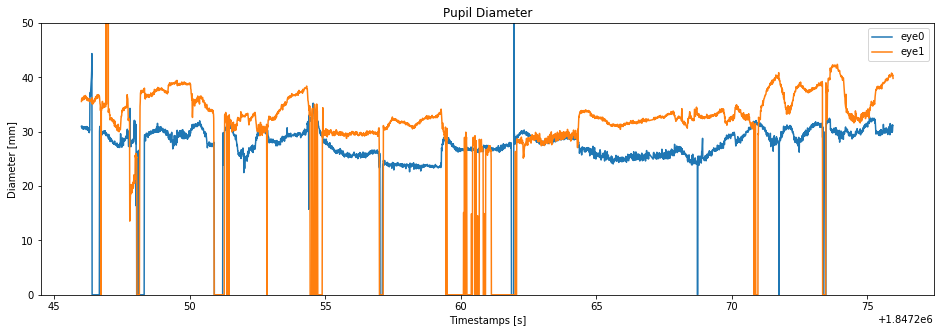

In [38]:
plt.figure(figsize=(16, 5))
plt.plot(eye0_df['timestamp'], eye0_df['diameter'])
plt.plot(eye1_df['timestamp'], eye1_df['diameter'])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [mm]')
plt.ylim((0, 50))
plt.title('Pupil Diameter')

As we can see there are spikes upwards and downwards in the data. These spikes are due to false positive pupil detections typically occuring during blinks. We can easily filter out these erroneous values using the `confidence` measure. 

Text(0.5,1,'Pupil Diameter (only high confidence values)')

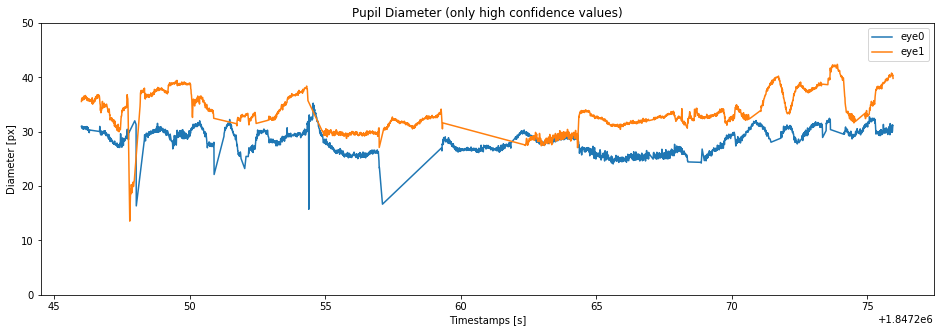

In [33]:
eye0_high_conf = eye0_df['confidence'] > 0.95
eye1_high_conf = eye1_df['confidence'] > 0.95

plt.figure(figsize=(16, 5))
plt.plot(eye0_df['timestamp'][eye0_high_conf], eye0_df['diameter'][eye0_high_conf])
plt.plot(eye1_df['timestamp'][eye1_high_conf], eye1_df['diameter'][eye1_high_conf])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [px]')
plt.ylim((0, 50))
plt.title('Pupil Diameter (only high confidence values)')

### Plot Pupil Positions
Next, we want to visualize the spatial distribution of pupil positions in the eye image in form of a scatter plot. We will color code each point with it's confidence value.

Text(0.5,1,'eye1')

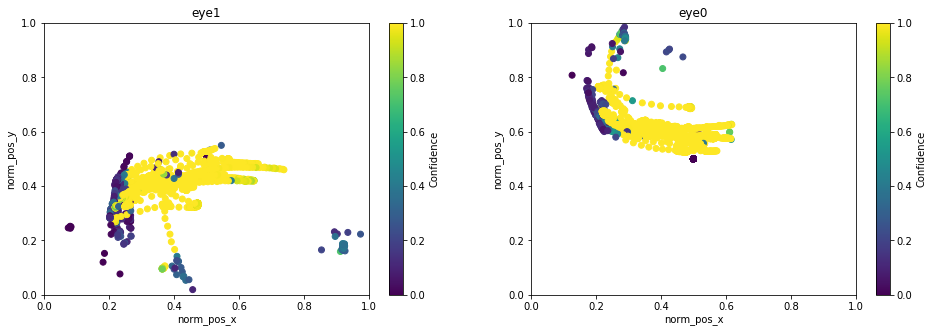

In [35]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 2)
plt.scatter(eye0_df['norm_pos_x'], eye0_df['norm_pos_y'], c=eye0_df['confidence'])
plt.colorbar().ax.set_ylabel('Confidence')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye0')


plt.subplot(1, 2, 1)
plt.scatter(eye1_df['norm_pos_x'], eye1_df['norm_pos_y'], c=eye1_df['confidence'])
plt.colorbar().ax.set_ylabel('Confidence')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye1')